# PGM Exercise - Preprocessing the training data

### Setup
Uncomment and run the below block for the first time, to install the required packages

In [ ]:
#!conda install -c conda-forge scikit-learn -y
#!conda install spacy -y
#!conda install tqdm -y
#!conda install pandas -y
#!python -m spacy download en_core_web_sm

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import spacy
import tqdm
from collections import Counter
import pandas as pd
import re

In [ ]:
data = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'))
nlp = spacy.load("en_core_web_sm")

print('Number of docs:', len(data.data))

Number of docs: 11314


## Convert docs to list of tokens

In [ ]:
unprocessed_docs = data['data']
def pre_process_docs_before_vocab(unprocessed_docs):
    docs = []
    patterns_and_replacements = {
        '<EMAIL>' : re.compile(r'^[\w\.-]+@[\w\.-]+\.\w+$')
    }

    for udoc in tqdm.tqdm_notebook(nlp.pipe(unprocessed_docs, batch_size=64), total=len(unprocessed_docs)):
        doc = []
        for token in udoc:
            if token.is_alpha:
                doc.append(token.text.lower())
            elif token.is_punct:
                # since punctuation would be one of the syntactic classes
                doc.append(token.text[0]) # why just text[0]? to handle cases like '!!!' or '...'
            elif token.is_space:
                # all space char including '\n' provides no meaning
                continue
            elif token.is_digit:
                doc.append('<NUM>')
            elif token.is_currency:
                doc.append('<CUR>')
            else:
                for replacement, pattern in patterns_and_replacements.items():
                    if pattern.match(token.text):
                        doc.append(replacement)
                        break
                else:
                    doc.append('<UNK>')
        docs.append(doc)
    return docs

docs = pre_process_docs_before_vocab(unprocessed_docs)

<ipython-input-4-1b81c784b61d>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for udoc in tqdm.tqdm_notebook(nlp.pipe(unprocessed_docs, batch_size=64), total=len(unprocessed_docs)):


  0%|          | 0/11314 [00:00<?, ?it/s]

## Build vocabulary

We will also remove the words that occur only once, since there is a good chance that those are typos

In [ ]:
def build_vocab(docs, rare_words_threshold):
    vocab = Counter()
    for doc in tqdm.tqdm_notebook(docs):
        vocab.update(doc)

    # ignore words that are rare
    vocab = Counter({key: count for key, count in vocab.items() if count > rare_words_threshold})
    return vocab

vocab = build_vocab(docs, rare_words_threshold=1)

<ipython-input-5-115373cf66e0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for doc in tqdm.tqdm_notebook(docs):


  0%|          | 0/11314 [00:00<?, ?it/s]

In [ ]:
def remove_out_of_vocab_tokens(docs, vocab):
    oov_count = 0
    for doc in docs:
        for ind, token in enumerate(doc):
            if token not in vocab:
                doc[ind] = '<OOV>'
                print("YES")
                oov_count += 1
    vocab['<OOV>'] = oov_count
    return docs, vocab


docs, vocab = remove_out_of_vocab_tokens(docs, vocab)

## View the processed data

In [ ]:
def compare_text_after_pre_processing(index, orig_docs, pre_processed_docs):
    print("------- Original -------")
    print(orig_docs[index])
    print("\n\n\n------- After preprocessing -------")
    print(' '.join(pre_processed_docs[index]))

print("Vocab size: ", len(vocab))
print("\n\nExample after preprocessing")
compare_text_after_pre_processing(index=0, orig_docs=data['data'], pre_processed_docs=docs)





most_common = vocab.most_common()[:30]
least_common = vocab.most_common()[-30:]

print("\n\n\n------- MOST COMMON ITEMS IN VOCAB -------")
print(pd.DataFrame(most_common, columns=['Word', 'Count']))


print("\n\n\n------- Least COMMON ITEMS IN VOCAB -------")
print(pd.DataFrame(least_common[::-1], columns=['Word', 'Count']))

In [ ]:
processed_docs = []
words = list(vocab.keys())
for doc in docs:
  doc_words = []
  for word in doc:
    word_idx = words.index(word)
    doc_words.append(word_idx)
  processed_docs.append(doc_words)




In [ ]:
import numpy as np

M = len(docs)
N = len(vocab)
T = 10
C = 5

alpha = 1 / T
beta = 1 / T
delta = 1 / C

theta_d_z = np.zeros((M, T))
phi_z_w = np.zeros((T, N))
phi_c_w = np.zeros((C, N))
z_d_i = [[0 for _ in range(len(doc))] for doc in docs]

i_d = np.zeros((M))
i_z = np.zeros((T))

In [ ]:
for d, doc in enumerate(processed_docs):
  for i, word in enumerate(doc):
    z_d_i[d][i] = i % T
    z = z_d_i[d][i]
    theta_d_z[d][z] += 1
    phi_z_w[z, word] += 1
    i_z[z] += 1
    i_d[d] += 1


In [ ]:
print(theta_d_z)

[[11. 11. 11. ... 11. 11. 11.]
 [11. 11. 10. ... 10. 10. 10.]
 [36. 36. 36. ... 35. 35. 35.]
 ...
 [13. 13. 13. ... 12. 12. 12.]
 [ 8.  8.  8. ...  7.  7.  7.]
 [ 7.  7.  6. ...  6.  6.  6.]]


In [ ]:
from tqdm.notebook import tqdm


iterations_num = 10

for iteration in tqdm(range(iterations_num)):
  for d, doc in enumerate(processed_docs):
    for i, word in enumerate(doc):
      z = z_d_i[d][i] # get the topc for word w_i in document doc

      # decrement counts for word word with associated topic z
      theta_d_z[d][z] -= 1
      phi_z_w[z, word] -= 1
      i_z[z] -= 1

      # sample new topic form a multinomial according to the formula
      p_d_t = (theta_d_z[d] + alpha) / (i_d[d] + T * alpha)
      p_t_w = (phi_z_w[:, word] + beta) / (i_z + N * beta + 1e9)
      p_z = p_d_t * p_t_w
      p_z /= np.sum(p_z)
      new_z = np.random.multinomial(1, p_z).argmax()

      # set z as the new topic and increment counts
      z_d_i[d][i] = new_z
      theta_d_z[d][new_z] += 1
      phi_z_w[new_z, word] += 1
      i_z[new_z] += 1




  0%|          | 0/10 [00:00<?, ?it/s]

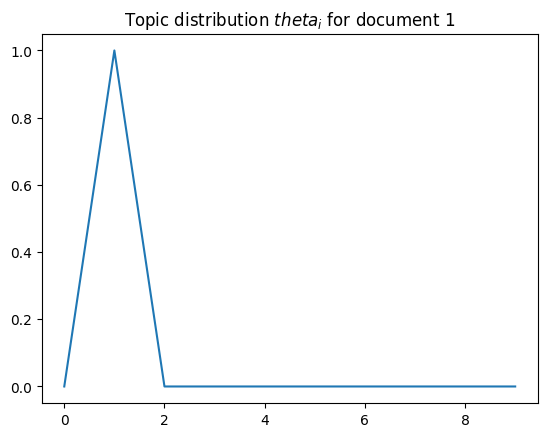

In [44]:
import matplotlib.pyplot as plt

i = 1
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i));

In [46]:
inv_vocabulary = {idx: w for idx, w in enumerate(words)}
n_top_words = 10
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: sanjay <OOV> perusal critique dig surviving artifacts deposit immortality distributing
Topic #1: <UNK> . the , <NUM> to of a and -
Topic #2: deflation disastrous <OOV> deposit closes critique dig surviving artifacts perusal
Topic #3: incidentally <OOV> artifacts dimension closes critique dig surviving deposit glowing
Topic #4: antidepressants edsel <OOV> perusal surviving artifacts deposit immortality distributing critique
Topic #5: sing yalanci speedisk dblspaced artifacts closes critique dig surviving immortality
Topic #6: baseless slippers <OOV> deposit closes critique dig surviving artifacts immortality
Topic #7: <OOV> alcoholic seemingly otis operative stimulate distributing perusal immortality deposit
Topic #8: skinny <OOV> closes drinks seemingly otis operative stimulate distributing perusal
Topic #9: homespun vauxhall coldest accompanying deposit closes critique dig surviving artifacts
